# Trading with Regression 


In [51]:
import pandas as pd
import numpy as np

import yfinance as yf
import pyfolio as pf
import talib as ta

# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-darkgrid')

# To ignore unwanted warnings
import warnings
warnings.filterwarnings("ignore")

## Importing Data 

In [2]:
# Import apple data
apple = yf.download('AAPL', start='2009-01-01', end='2022-04-26')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Check for NaNs
apple.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
apple.shape

(3351, 6)

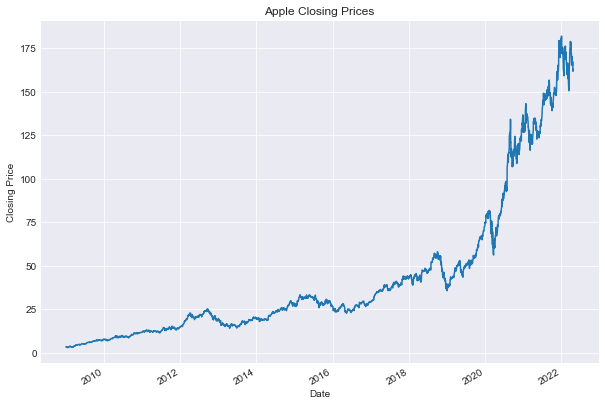

In [5]:
# Plotting the closing price of APPL
apple['Close'].plot(figsize=(10, 7))
plt.title('Apple Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

## Creating Input Parameters
Custom indicators will be built in order to help make the predictions more accurate. Technical analysis indicators will also be added.

***Techinal Indicators***
1. `S_3`, `S_15`, `S_30`: 3-days, 15-days, and 30-days moving average for Apple close prices
2. `Corr`: THe correlation between the closing price and the 3-day moving average
3. `ADX`: ADX is used to quantify trend strength. ADX calculations are based on a moving average of price range expansion over a given period of time.

***Custom Indicators***
1. `Std_U` and `Std_D`: Difference between the high and open, and the difference between open and low
2. `OD` and `OL`: Difference between the Open and yesterdays open, and the difference between open and yesterdays close

In [6]:
# Indicator Creation

# 3-day Moving Average
apple['S_3'] = ta.MA(apple['Close'], timeperiod=3, matype=0)

# 15-day Moving Average
apple['S_15'] = ta.MA(apple['Close'], timeperiod=15, matype=0)

# 30-day Moving Average
apple['S_30'] = ta.MA(apple['Close'], timeperiod=30, matype=0)

# Correlation Calculation
apple['Corr'] = apple['Close'].shift(1).rolling(window=10).corr(apple['Close'].shift(1))

# Std_U and Std_D
apple['Std_U'] = apple['High'] - apple['Close']
apple['Std_D'] = apple['Open'] - apple['Low']

# OD and OL
apple['OD'] = apple['Open'] - apple['Open'].shift(1)
apple['OL'] = apple['Open'] - apple['Close'].shift(1)

# ADX
apple['ADX'] = ta.ADX(apple['High'], apple['Low'], apple['Close'], timeperiod=14)

apple.head()

,Open,High,Low,Close,Adj Close,Volume,S_3,S_15,S_30,Corr,Std_U,Std_D,OD,OL,ADX
Date,,,,,,,,,,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.775245,746015200,NaN,NaN,NaN,NaN,0.010358,0.025714,NaN,NaN,NaN
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.892371,1181608400,NaN,NaN,NaN,NaN,0.057143,0.016429,0.260357,0.086429,NaN
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.844665,1289310400,3.313690,NaN,NaN,NaN,0.148214,0.127143,0.099286,0.048929,NaN
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.783196,753048800,3.316786,NaN,NaN,NaN,0.053214,0.055358,-0.147857,-0.043214,NaN
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.834879,673500800,3.294405,NaN,NaN,NaN,0.016072,0.013929,-0.049286,-0.020714,NaN


## Creating X and y dataset
***Three datasets to be created***
1. `X`: (Independent variable) contains the features which are created
2. `yU`: (Dependent variable) contains the data which will be predicted -> upward deviation
3. `yD`: (Dependent variable) contains the data which will be predicted -> downward deviation

In [7]:
# X -> Independent Variable
X = apple[['Open', 'S_3', 'S_15', 'S_30', 'Corr', 'OD', 'OL', 'ADX']]
X.head()

,Open,S_3,S_15,S_30,Corr,OD,OL,ADX
Date,,,,,,,,
2009-01-02,3.067143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,3.327500,NaN,NaN,NaN,NaN,0.260357,0.086429,NaN
2009-01-06,3.426786,3.313690,NaN,NaN,NaN,0.099286,0.048929,NaN
2009-01-07,3.278929,3.316786,NaN,NaN,NaN,-0.147857,-0.043214,NaN
2009-01-08,3.229643,3.294405,NaN,NaN,NaN,-0.049286,-0.020714,NaN


In [8]:
# yU -> Dependent Variable
yU = apple['Std_U']
yU.head()

Date
2009-01-02    0.010358
2009-01-05    0.057143
2009-01-06    0.148214
2009-01-07    0.053214
2009-01-08    0.016072
Name: Std_U, dtype: float64

In [9]:
yD = apple['Std_D']
yD.head()

Date
2009-01-02    0.025714
2009-01-05    0.016429
2009-01-06    0.127143
2009-01-07    0.055358
2009-01-08    0.013929
Name: Std_D, dtype: float64

***

## Data Cleaning

In [10]:
# Check for NaN values, drop them
apple.isna().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
S_3           2
S_15         14
S_30         29
Corr         10
Std_U         0
Std_D         0
OD            1
OL            1
ADX          27
dtype: int64

In [11]:
# Dropping NaN
apple.dropna(inplace=True)

# Checking again for NaN
apple.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
S_3          0
S_15         0
S_30         0
Corr         0
Std_U        0
Std_D        0
OD           0
OL           0
ADX          0
dtype: int64

In [12]:
X = apple[['Open', 'S_3', 'S_15', 'S_30', 'Corr', 'OD', 'OL', 'ADX']]
X.head()

,Open,S_3,S_15,S_30,Corr,OD,OL,ADX
Date,,,,,,,,
2009-02-13,3.535357,3.514881,3.398833,3.268226,1.0,0.112857,-0.010000,18.082086
2009-02-17,3.459643,3.487619,3.410476,3.272726,1.0,-0.075714,-0.081786,17.297998
2009-02-18,3.394643,3.429286,3.419143,3.272476,1.0,-0.065000,0.018572,16.118812
2009-02-19,3.334643,3.327857,3.410667,3.269643,1.0,-0.060000,-0.035714,15.602499
2009-02-20,3.192857,3.288214,3.406381,3.269869,1.0,-0.141786,-0.044286,15.397260


In [13]:
# yU -> Dependent Variable
yU = apple['Std_U']
yU.head()

Date
2009-02-13    0.027857
2009-02-17    0.089643
2009-02-18    0.052857
2009-02-19    0.128928
2009-02-20    0.042857
Name: Std_U, dtype: float64

In [14]:
yD = apple['Std_D']
yD.head()

Date
2009-02-13    0.031071
2009-02-17    0.092500
2009-02-18    0.083214
2009-02-19    0.116429
2009-02-20    0.014286
Name: Std_D, dtype: float64

***

## Data Preprocessing
### Steps 
1. ***Scaling***
2. ***Model Fit (Linear Regression)***
3. ***Creating Pipeline***
4. ***Hyperparameters***
5. ***Grid Search Cross-Validation***
6. ***Prediction***

### Creating Pipeline
Two steps in the pipeline:
1. Scaling the data. 
2. Fitting the data using the linear regression model.

In [15]:
# Creating the Pipeline
steps = [('scaler', StandardScaler()),
         ('linear', LinearRegression())]

# Defining Pipeline
pipeline = Pipeline(steps)

### Hyperparameters

In [16]:
# Here we are using intercept as hyperparameter
parameters = {'linear__fit_intercept': [0, 1]}

### Grid Search Cross-Validation

In [17]:
# TimeSeriesSplit cross validation
ap_cv = TimeSeriesSplit(n_splits=5)

# Gridsearch function
reg = GridSearchCV(pipeline, parameters, cv=ap_cv)

### Split Train and Test Data
1. First, 70% of data is used for training and the remaining data for testing.
2. Fit the training data to a grid search function.

In [18]:
split_ratio = .70

# Splitting the data
split = int(split_ratio * len(apple))

# Train Dataset
X_train = X[:split]
yU_train = yU[:split]
yD_train = yD[:split]

# Test Dataset
X_test = X[split:]

### Prediction
Fit the linear regression model on the training dataset and predict the upward deviation in the test dataset. 

#### Upward Deviation

In [19]:
# Fit the model
reg.fit(X_train, yU_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

In [20]:
# Print best parameter
print(reg.best_params_)

{'linear__fit_intercept': 1}


In [21]:
# Predict the upward deviation
yU_predict = reg.predict(X_test)

#### Downward Deviation

In [22]:
# Fit the model
reg.fit(X_train, yD_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

In [23]:
# Print best parameter
print(reg.best_params_)

{'linear__fit_intercept': 1}


In [24]:
# Predict the upward deviation
yD_predict = reg.predict(X_test)

#### Adding predicted columns to X_test dataset

In [25]:
# Create new column in X_test
X_test['yU_predict'] = yU_predict
X_test['yD_predict'] = yD_predict

# Assign zero to all the negative predicted values to take into account real life conditions
X_test.loc[X_test['yU_predict'] < 0, 'yU_predict'] = 0
X_test.loc[X_test['yD_predict'] < 0, 'yD_predict'] = 0

Use the predicted upside deviation values to calculate the high price and the predicted downside deviation values to calculate the low price.

In [26]:
# Add open values in ['yU_predict'] to get the predicted high column
X_test['P_H'] = X_test['Open']+X_test['yU_predict']

# Subtract ['yD_predict'] values in open to get the predicted low column.
X_test['P_L'] = X_test['Open']-X_test['yD_predict']

# Print tail of apple_prices dataframe
X_test.tail()

,Open,S_3,S_15,S_30,Corr,OD,OL,ADX,yU_predict,yD_predict,P_H,P_L
Date,,,,,,,,,,,,
2022-04-19,165.020004,165.919998,171.652000,167.570667,1.0,1.100006,-0.050003,15.405105,0.717657,0.575000,165.737661,164.445004
2022-04-20,168.759995,166.566666,170.869999,167.897000,1.0,3.739990,1.360001,14.775393,2.135936,2.240586,170.895930,166.519409
2022-04-21,168.910004,167.016663,170.113332,168.012667,1.0,0.150009,1.680008,14.007564,2.639600,2.996053,171.549603,165.913951
2022-04-22,166.460007,165.146662,169.258665,168.121666,1.0,-2.449997,0.040009,13.844783,3.539589,3.850152,169.999596,162.609855
2022-04-25,161.119995,163.696665,168.496665,168.393333,1.0,-5.340012,-0.669998,14.330863,1.170342,1.233845,162.290337,159.886150


Add the `Close`, `High`, and `Low` columns from `apple` because those columns will be used to calculate strategy return
Use the split function to get only the test part of `apple`.

In [27]:
# Copy columns from gold_prices to X_test
X_test[['Close', 'High', 'Low']] = apple[['Close', 'High', 'Low']][split:]
X_test.tail()

,Open,S_3,S_15,S_30,Corr,OD,OL,ADX,yU_predict,yD_predict,P_H,P_L,Close,High,Low
Date,,,,,,,,,,,,,,,
2022-04-19,165.020004,165.919998,171.652000,167.570667,1.0,1.100006,-0.050003,15.405105,0.717657,0.575000,165.737661,164.445004,167.399994,167.820007,163.910004
2022-04-20,168.759995,166.566666,170.869999,167.897000,1.0,3.739990,1.360001,14.775393,2.135936,2.240586,170.895930,166.519409,167.229996,168.880005,166.100006
2022-04-21,168.910004,167.016663,170.113332,168.012667,1.0,0.150009,1.680008,14.007564,2.639600,2.996053,171.549603,165.913951,166.419998,171.529999,165.910004
2022-04-22,166.460007,165.146662,169.258665,168.121666,1.0,-2.449997,0.040009,13.844783,3.539589,3.850152,169.999596,162.609855,161.789993,167.869995,161.500000
2022-04-25,161.119995,163.696665,168.496665,168.393333,1.0,-5.340012,-0.669998,14.330863,1.170342,1.233845,162.290337,159.886150,162.880005,163.169998,158.460007


***

## Signal Creation 
Use the predicted high and predicted low values to determine whether to buy or sell apple the next day.

Sell apple when
1. The actual high value is greater than the predicted high value. 
2. The actual low value is greater than the predicted low value.

Buy apple when 
1. The actual high value is less than the predicted high value.  
2. The actual low value is less than the predicted low value.

In [33]:
# Create a new dataset with close, high, P_H, P_L, Low
test_dataset = X_test[['Close', 'High', 'P_H', 'Low', 'P_L']]

test_dataset.head()

,Close,High,P_H,Low,P_L
Date,,,,,
2018-05-10,47.509998,47.592499,46.935001,46.912498,46.935001
2018-05-11,47.147499,47.514999,47.613783,46.862499,47.181194
2018-05-14,47.037498,47.382500,47.410697,46.965000,47.090985
2018-05-15,46.610001,46.767502,46.962495,46.275002,46.459997
2018-05-16,47.044998,47.115002,46.517502,46.500000,46.517502


In [34]:
# Signal Creation
# Initialising signal column to be zero
test_dataset['Signal'] = 0

# When selling, assigning signal value as -1
test_dataset.loc[(test_dataset['High'] > test_dataset['P_H']) & (
    test_dataset['Low'] > test_dataset['P_L']), 'Signal'] = -1

# When buying, assigning signal value as +1
test_dataset.loc[(test_dataset['High'] < test_dataset['P_H']) & (
    test_dataset['Low'] < test_dataset['P_L']), 'Signal'] = 1

## Strategy Returns

In [43]:
# Compute Apple returns
test_dataset['appl_returns'] = test_dataset['Close'].pct_change()

# Compute strategy returns
test_dataset['strategy_returns'] = test_dataset['appl_returns'] * \
    (test_dataset['Signal'].shift(1))

# Printing tail of the test_dataset
test_dataset

,Close,High,P_H,Low,P_L,Signal,appl_returns,strategy_returns
Date,,,,,,,,
2018-05-10,47.509998,47.592499,46.935001,46.912498,46.935001,0,NaN,NaN
2018-05-11,47.147499,47.514999,47.613783,46.862499,47.181194,1,-0.007630,-0.000000
2018-05-14,47.037498,47.382500,47.410697,46.965000,47.090985,1,-0.002333,-0.002333
2018-05-15,46.610001,46.767502,46.962495,46.275002,46.459997,1,-0.009088,-0.009088
2018-05-16,47.044998,47.115002,46.517502,46.500000,46.517502,0,0.009333,0.009333
...,...,...,...,...,...,...,...,...
2022-04-19,167.399994,167.820007,165.737661,163.910004,164.445004,0,0.014115,-0.014115
2022-04-20,167.229996,168.880005,170.895930,166.100006,166.519409,1,-0.001016,-0.000000
2022-04-21,166.419998,171.529999,171.549603,165.910004,165.913951,1,-0.004844,-0.004844


## Plot the GLD Returns and Strategy Returns
Plot `apple_returns` and `test_dataset` in one plot.

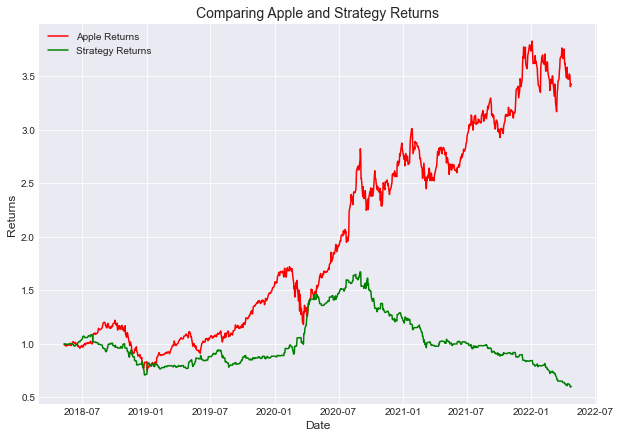

In [40]:
plt.figure(figsize=(10, 7))

# Plotting gld_returns
plt.plot(((test_dataset['appl_returns'][:]+1).cumprod()),
         color='r', label='Apple Returns')

# Plotting test_dataset
plt.plot(((test_dataset['strategy_returns'][:]+1).cumprod()),
         color='g', label='Strategy Returns')

# x-labeling
plt.xlabel('Date', fontsize=12)

# y-labeling
plt.ylabel('Returns', fontsize=12)

# Titlename
plt.title('Comparing Apple and Strategy Returns', fontsize=14)
plt.legend()
plt.show()

## Trade Details and Strategy Analytics
Trade analytics takes `data`, `Close`, and `Signal` as  input parameters. And it provides all information regarding the number of long, short positions, gross profit, and loss using the `trades` dataframe.
The syntax of the function is as follows:

```python
get_trades() 
```
Parameters: 

    1. data: dataframe to be used for trade analysis
    2. Close: Close price column of dataframe
    3. Signal: Signal column of dataframe
    
Returns: 

    1. Position- long or short 
    2. Entry date of long or short position
    3. Entry price of long or short position
    4. Exit Date of long or short position
    5. Exit price of long or short position 

In [54]:
def get_trades(data, close_column, signal_column):
    """Function to generate trade details
    """
    # Intializing trades dataframe
    trades = pd.DataFrame()

    # There are no current positions open at the beginning
    current_position = 0

    # Creating an empty string for entry_date
    entry_date = ''

    for i in data.index:

        # Save the signal generated on date i in 'new_position'
        new_position = data.loc[i, signal_column]

        # Don't take any action if the current_position is equal to the signal generated at date i.
        # The below code will run if the signal generated is not equal to current_position.
        if new_position != current_position:

            # The below code will run if the entry_date is not empty
            if entry_date != '':

                # save entry price in entry_price
                entry_price = data.loc[entry_date, close_column]

                # Since the signal and current_position are not equal, we exit the position at date i
                exit_date = i

                # Save exit price in exit_price
                exit_price = data.loc[exit_date, close_column]

                # Create a dataframe trade_details with trade details
                trade_details = pd.DataFrame(
                    [(current_position, entry_date, entry_price, exit_date, exit_price)])

                # Update the trades dataframe in every loop
                trades = trades.append(trade_details, ignore_index=True)

                # Reset the entry_date
                entry_date = ''

            # If the new_position i.e. signal generated at i is not '0' and also not equal to current_position, we will enter either short or long trade
            if new_position != 0:

                # Save entry date of trade in entry_date
                entry_date = i

            # Update the current_position with signal generated on date i
            current_position = new_position

    # Creating below five columns in trades dataframe.
    trades.columns = ['Position', 'Entry Date',
                      'Entry Price', 'Exit Date', 'Exit Price']

    # Create a column in trades dataframe to store the profit and loss from each trade
    trades['PnL'] = (trades['Exit Price'] -
                     trades['Entry Price']) * trades['Position']

    # Returns 'trades' dataframe
    return trades

In [55]:
def get_analytics(trades):
    """Function to generate strategy analytics
    """

    analytics = pd.DataFrame(index=['Strategy'])
    # Number of long trades
    analytics['num_of_long'] = len(trades.loc[trades.Position == 1])
    # Number of short trades
    analytics['num_of_short'] = len(trades.loc[trades.Position == -1])
    # Total number of trades
    analytics['total_trades'] = analytics.num_of_long + analytics.num_of_short

    # Gross Profit
    analytics['gross_profit'] = trades.loc[trades.PnL > 0].PnL.sum()
    # Gross Loss
    analytics['gross_loss'] = trades.loc[trades.PnL < 0].PnL.sum()

    # Net Profit
    analytics['net_profit'] = trades.PnL.sum()

    # Profitable trades
    analytics['winners'] = len(trades.loc[trades.PnL > 0])
    # Loss-making trades
    analytics['losers'] = len(trades.loc[trades.PnL <= 0])
    # Win percentage
    analytics['win_percentage'] = 100*analytics.winners/analytics.total_trades
    # Loss percentage
    analytics['loss_percentage'] = 100*analytics.losers/analytics.total_trades
    # Per trade profit/loss of winning trades
    analytics['per_trade_PnL_winners'] = trades.loc[trades.PnL > 0].PnL.mean()
    # Per trade profit/loss of losing trades
    analytics['per_trade_PnL_losers'] = trades.loc[trades.PnL <= 0].PnL.mean()

    return analytics.T

In [56]:
strategy_data = test_dataset

In [46]:
# Using get_trades function to evalute trades detail
trades = get_trades(strategy_data, 'Close', 'Signal')
print('Trade Details')

# Printing trades datframe
trades.head()

Trade Details


,Position,Entry Date,Entry Price,Exit Date,Exit Price,PnL
0,1,2018-05-11,47.147499,2018-05-16,47.044998,-0.102501
1,1,2018-05-17,46.747501,2018-05-18,46.577499,-0.170002
2,-1,2018-05-21,46.907501,2018-05-22,46.790001,0.117500
3,-1,2018-05-23,47.090000,2018-05-24,47.037498,0.052502
4,1,2018-05-24,47.037498,2018-05-25,47.145000,0.107502


## Visualise the Entry and Exit

Visualize long and short entry position for clear understanding of our trading strategy. 

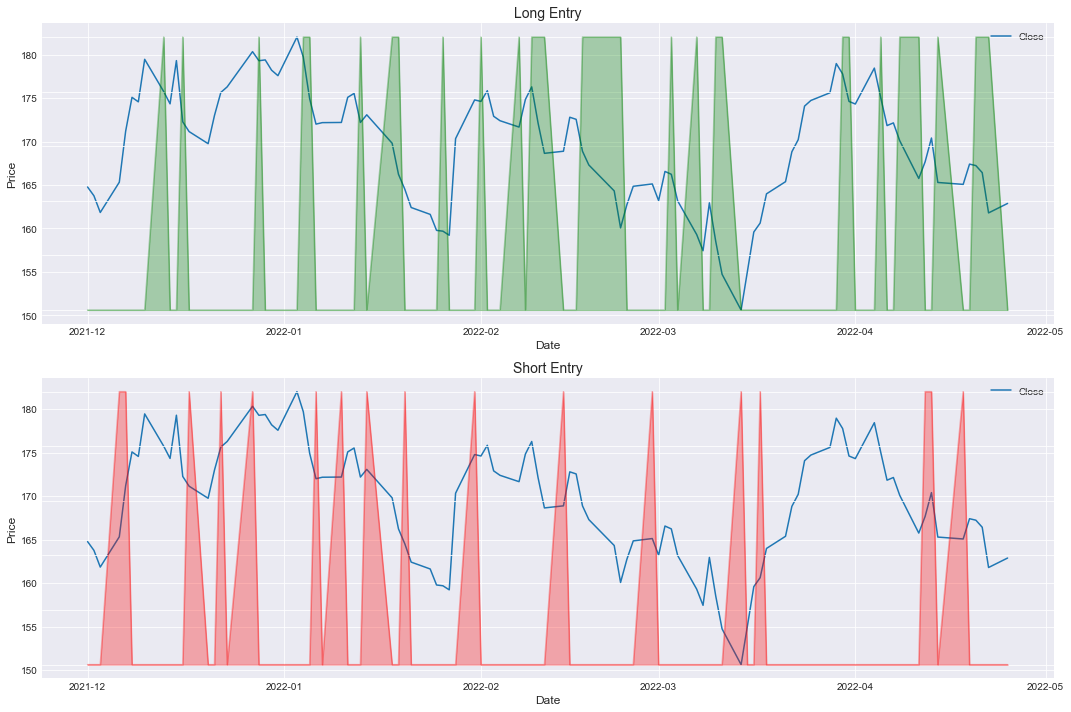

In [47]:
import matplotlib.pyplot as plt

# Showing the last 100 points for illustration purpose
test_dataset_for_plot = strategy_data[-100:]

# When signal is 1 we take long entry
test_dataset_for_plot['long_entry'] = test_dataset_for_plot.Signal == 1

# When signal is -1 we take short entry
test_dataset_for_plot['short_entry'] = test_dataset_for_plot.Signal == -1

fig = plt.figure(figsize=(15, 10))

# Sub plot for the long entry
ax = fig.add_subplot(211)

# Plotting close price
ax.plot(test_dataset_for_plot['Close'], label='Close')

# Set the title and axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Long Entry', fontsize=14)
ax.legend()


# Twinx() creates a new axes with an invisible x-axis and y axis positioned opposite to the original one
ax2 = ax.twinx()

# Plotting long entry
ax2.plot(test_dataset_for_plot['long_entry'], color='g', alpha=0.3)
ax2.fill_between(test_dataset_for_plot['long_entry'].index,
                 test_dataset_for_plot['long_entry'].values, color='g', alpha=0.3)
ax2.tick_params(labelright=False)

# Sub plot for the short position
ax = fig.add_subplot(212)

# Plot the close price
ax.plot(test_dataset_for_plot['Close'], label='Close')


# Set the title and axis labels
ax.set_title('Short Entry', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.legend()

# Plotting short entry
ax2 = ax.twinx()
ax2.plot(test_dataset_for_plot['short_entry'], color='r', alpha=0.3)
ax2.fill_between(test_dataset_for_plot['short_entry'].index,
                 test_dataset_for_plot['short_entry'].values, color='r', alpha=0.3)
ax2.tick_params(labelright=False)

plt.tight_layout()
plt.show()

### Trade Analytics
Trade analytics function gives statistical information of trading profile such as number of long entries, number of short entries, etc.

In [57]:
# Calling get_analytics to analyze trades
analytics = get_analytics(trades)
print('Trade Analytics')

# Rounding off to two decimal places
round(analytics, 2)

Trade Analytics


,Strategy
num_of_long,207.00
num_of_short,191.00
total_trades,398.00
gross_profit,243.27
gross_loss,-339.63
net_profit,-96.36
winners,207.00
losers,191.00
win_percentage,52.01
loss_percentage,47.99


In [58]:
# Caculating close price change percentage
strategy_data['returns'] = strategy_data.Close.pct_change()

# Strategy return depends on the last day signal
strategy_data['strategy_returns'] = strategy_data['returns'] * \
    strategy_data['Signal'].shift(1)
strategy_data.head()

,Close,High,P_H,Low,P_L,Signal,appl_returns,strategy_returns,returns
Date,,,,,,,,,
2018-05-11,47.147499,47.514999,47.613783,46.862499,47.181194,1,-0.007630,NaN,NaN
2018-05-14,47.037498,47.382500,47.410697,46.965000,47.090985,1,-0.002333,-0.002333,-0.002333
2018-05-15,46.610001,46.767502,46.962495,46.275002,46.459997,1,-0.009088,-0.009088,-0.009088
2018-05-16,47.044998,47.115002,46.517502,46.500000,46.517502,0,0.009333,0.009333,0.009333
2018-05-17,46.747501,47.227501,47.322112,46.590000,46.699527,1,-0.006324,-0.000000,-0.006324


Start date,2018-05-14
End date,2022-04-25
Total months,47
,Backtest
Annual return,-12.1%
Cumulative returns,-40.0%
Annual volatility,23.3%
Sharpe ratio,-0.44
Calmar ratio,-0.19
Stability,0.00
Max drawdown,-64.3%


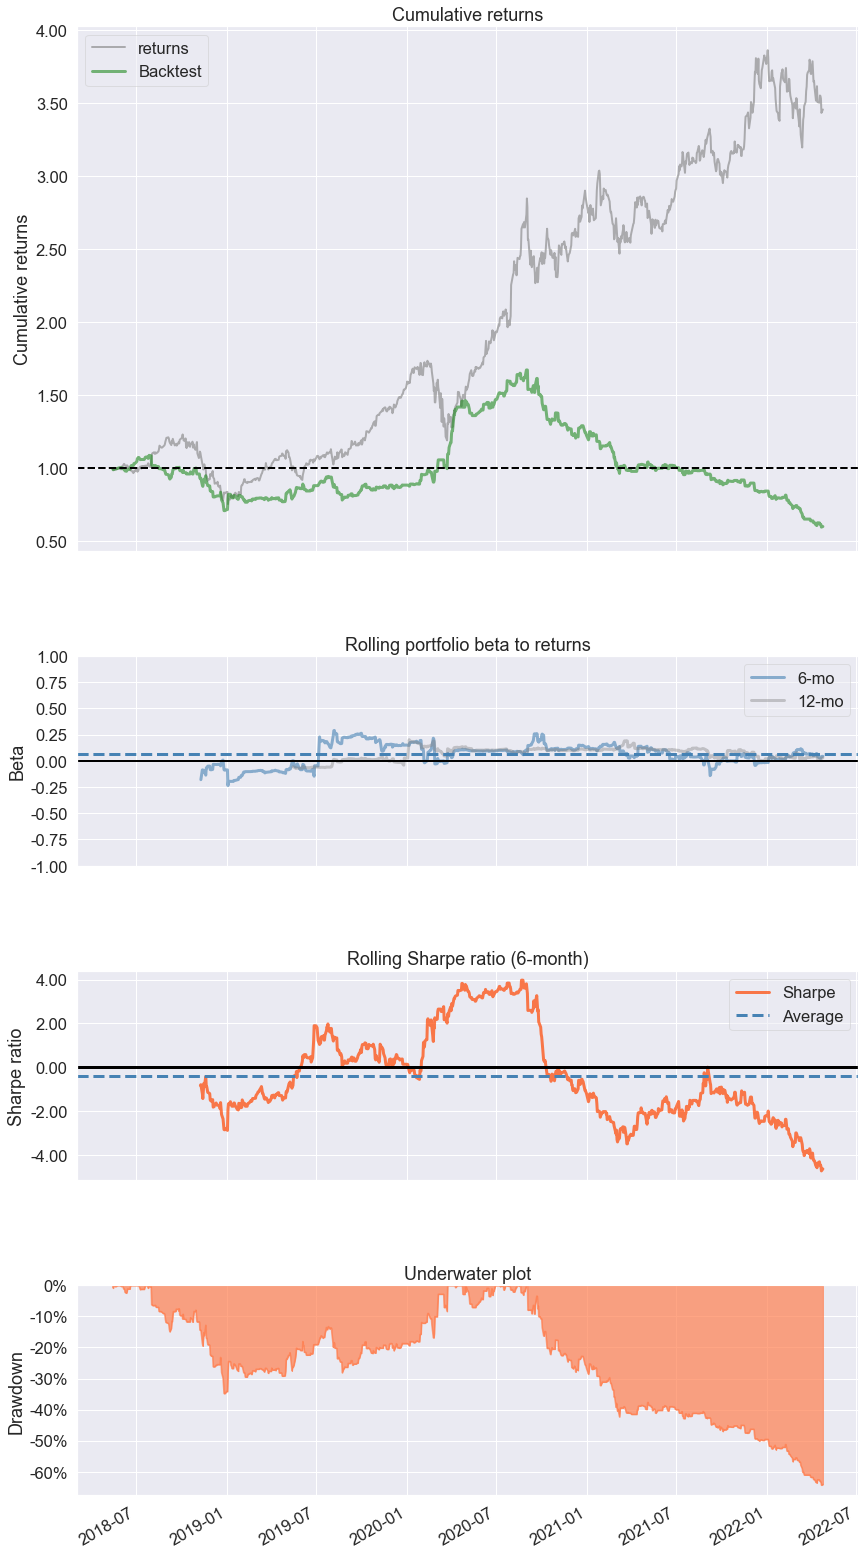

In [59]:
#Checking for NaN values
strategy_data.isna().sum()

# Dropping the NaN values 
strategy_data.dropna(inplace = True)
strategy_data.head()

# Creating pyfolio tear sheet
pf.create_simple_tear_sheet(strategy_data['strategy_returns'], benchmark_rets = strategy_data['returns']) 